In [15]:
import numpy as np
import pandas as pd
import csv
import random
import seaborn as sns

# Import packages for pre-processing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


# Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Cosine Similarity 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

# Data Modelling
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix

#source: https://github.com/fraunhofer-iais/arabic_nlp/

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\YAS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YAS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Functions

In [16]:
def load_train(path='arabic_nlp/'):
    # Load the dataset
    train_data = pd.read_csv('arabic_nlp/train.csv')
    train_data = pd.DataFrame(train_data, columns=['premise', 'hypothesis', 'label'])

    # Remove all the rows labeled as '-' and NaN values
    train_data = train_data.loc[train_data['label'] != '-']
    train_data = train_data.dropna()

    # Shuffle data
    train_data = train_data.sample(frac=1, random_state=203)
    return train_data



def load_test(path='arabic_nlp/'):
    # Load the dataset
    test_data = pd.read_csv('arabic_nlp/test.csv')
    test_data = pd.DataFrame(test_data, columns=['premise', 'hypothesis', 'label'])

    # Remove all the rows labeled as '-' and NaN values
    test_data = test_data.loc[test_data['label'] != '-']
    test_data = test_data.dropna()

    return test_data

def clean():
    pass # this is done in main



In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_data(train_data, test_data):
    max_features = 500
    # Fit the vectorizer to the pair of training data and transform it separetely
    vectorizer = TfidfVectorizer(max_features = max_features)
    # Join pair of sentences
    pair_train = [' '.join([s1,s2]) for s1,s2 in train_data[['clean_sent1', 'clean_sent2']].values]
    train_vec = vectorizer.fit(pair_train)

    # Transform sentence independently
    X_train1 = train_vec.transform(train_data['clean_sent1'].values)
    X_train2 = train_vec.transform(train_data['clean_sent2'].values)
    #Vectorize test sentences
    X_test1 = train_vec.transform(test_data['clean_sent1'].values)
    X_test2 = train_vec.transform(test_data['clean_sent2'].values)

    # print(X_train1.shape) (10000, 300)
    # print(X_train2.shape) (10000, 300)
    return X_train1, X_train2, X_test1, X_test2


# Create a Dictionary of labels with its cosine values
def dic_labels(x,y):
    
    dic = {
    'neutral': [],
    'entailment': [],
    'contradiction': []
    }
    
    for i,j in zip(x,y):
        if j == 'entailment':
            dic[j].append(i)
        elif j == 'neutral':
            dic[j].append(i)
        else:
            dic[j].append(i)
    
    return dic


def plot_similarity(train_data, X_train1, X_train2):
    # Compute distance metrics
    cosine = lambda x,y: cosine_similarity(x.reshape(1,-1), y.reshape(1,-1)).flatten()[0]
    euclidean = lambda x,y: euclidean_distances(x.reshape(1,-1), y.reshape(1,-1)).flatten()[0]

    train_data['dist_cos'] = list(map(cosine, X_train1, X_train2))
    train_data['dist_euc'] = list(map(euclidean, X_train1, X_train2))

    dist_cos = dic_labels(train_data['dist_cos'].values, train_data['gold_label'].values)
    dist_euc = dic_labels(train_data['dist_euc'].values, train_data['gold_label'].values)

    # Cosine scores distribution by labels
    metric = ['Cosine', 'Euclidean']
    results = [dist_cos, dist_euc]
    fig, ax = plt.subplots(1,2, figsize=(15,5))

    for i in range(0,2):
        sb.kdeplot(results[i]['neutral'], label='neutral', color='blue', ax=ax[i])
        sb.kdeplot(results[i]['entailment'], label='entailment', color='green', ax=ax[i])
        sb.kdeplot(results[i]['contradiction'], label='contradiction', color='red', ax=ax[i])
        ax[i].set_title(metric[i] + ' Distribution by labels')
        ax[i].legend()
    plt.show()

### Main

In [18]:
# main
train_data = load_train()
test_data = load_test()

In [19]:
# main
train_data['clean_sent1'] = train_data['premise']
train_data['clean_sent2'] = train_data['hypothesis']

test_data['clean_sent1'] = test_data['premise']
test_data['clean_sent2'] = test_data['hypothesis']

import tnkeeh as tn
# source: https://github.com/ARBML/tnkeeh/blob/master/tnkeeh/tnkeeh.py
tn.clean_data_frame(train_data, 'clean_sent1', segment = False, remove_special_chars = True, 
        remove_english = True, normalize = False, remove_diacritics = True,
        excluded_chars = [], remove_tatweel = True, remove_html_elements = True,
        remove_links = True, remove_twitter_meta = True, remove_long_words = True,
        remove_repeated_chars = True)
tn.clean_data_frame(train_data, 'clean_sent2', segment = False, remove_special_chars = True, 
        remove_english = True, normalize = False, remove_diacritics = True,
        excluded_chars = [], remove_tatweel = True, remove_html_elements = True,
        remove_links = True, remove_twitter_meta = True, remove_long_words = True,
        remove_repeated_chars = True)
tn.clean_data_frame(test_data, 'clean_sent1', segment = False, remove_special_chars = True, 
        remove_english = True, normalize = False, remove_diacritics = True,
        excluded_chars = [], remove_tatweel = True, remove_html_elements = True,
        remove_links = True, remove_twitter_meta = True, remove_long_words = True,
        remove_repeated_chars = True)
tn.clean_data_frame(test_data, 'clean_sent2', segment = False, remove_special_chars = True, 
        remove_english = True, normalize = False, remove_diacritics = True,
        excluded_chars = [], remove_tatweel = True, remove_html_elements = True,
        remove_links = True, remove_twitter_meta = True, remove_long_words = True,
        remove_repeated_chars = True)

,premise,hypothesis,label,clean_sent1,clean_sent2
0,رجل يعزف على الفلوت,الرجل يلعب بمهارة على الغيتار,1,رجل يعزف على الفلوت,الرجل يلعب بمهارة على الغيتار
1,البغدادي المحمودي يعرض على المعارضة وقفا ل إط...,رئيس الحكومة الليبية مستعدون ل وقف إطلاق النا...,2,البغدادي المحمودي يعرض على المعارضة وقفا ل إط...,رئيس الحكومة الليبية مستعدون ل وقف إطلاق النا...
2,طفلان وشخص بالغ لا يقفون بجانب أحد أطراف الشجرة,يقف طفلان وشخص بالغ بجانب شجرة,2,طفلان وشخص بالغ لا يقفون بجانب أحد أطراف الشجرة,يقف طفلان وشخص بالغ بجانب شجرة
3,كلبان بنيان يلعبان مع الفريسبي في الماء,كلبان بنيان يلعبان مع الطائر الطائر في الماء,0,كلبان بنيان يلعبان مع الفريسبي في الماء,كلبان بنيان يلعبان مع الطائر الطائر في الماء
4,كان ستيف هاريس، عالم الأحياء الجزيئية من تكساس...,رفض ستيف هاريس مغادرة منزله لأي سبب.,2,كان ستيف هاريس عالم الأحياء الجزيئية من تكساس ...,رفض ستيف هاريس مغادرة منزله لأي سبب
...,...,...,...,...,...
3100,يا إلهي لقد كانت دراستي الأساسية في اللغة الإن...,يعود سبب فقري إلى أحد رواد اللغة الإنجليزية، ...,2,يا إلهي لقد كانت دراستي الأساسية في اللغة الإن...,يعود سبب فقري إلى أحد رواد اللغة الإنجليزية ول...
3101,المهمة المباشرة هي إنهاء الحرب وإعادة توحيد ال...,مات الآلاف من الناس وهم يقاتلون في هذه الحرب.,1,المهمة المباشرة هي إنهاء الحرب وإعادة توحيد ال...,مات الآلاف من الناس وهم يقاتلون في هذه الحرب
3102,ضرب بعناية لحيته الذهبية.,كان لديه لحية ذات لون ذهبي.,0,ضرب بعناية لحيته الذهبية,كان لديه لحية ذات لون ذهبي
3103,نعم، هذا صحيح، أو أن أراهم يحجبون هذا، كما قلت...,أعتقد أنه يجب أن تكون هناك قواعد حول الأسلحة ا...,0,نعم هذا صحيح أو أن أراهم يحجبون هذا كما قلت من...,أعتقد أنه يجب أن تكون هناك قواعد حول الأسلحة ا...


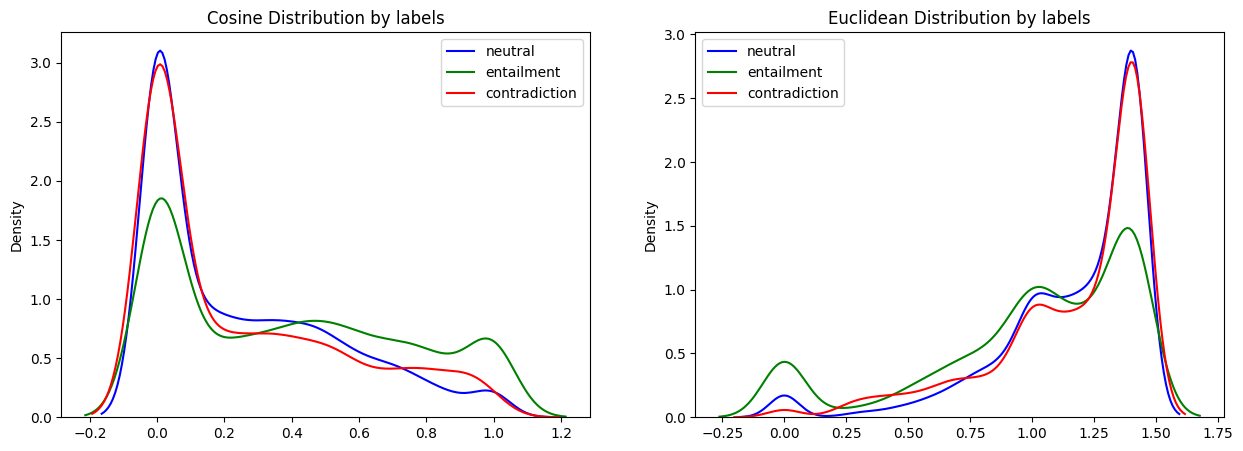

In [20]:
# main: Encode gold_label DONE
# (0: ENTAILMENT, 1: NEUTRAL, 2:CONTRADICTION)
dict_label = {0:'entailment', 1:'neutral', 2:'contradiction'}
train_data['gold_label'] = train_data['label'].map(lambda x: dict_label[x])
test_data['gold_label'] = test_data['label'].map(lambda x: dict_label[x])

# main: Vectorize
X_train1, X_train2, X_test1, X_test2 = vectorize_data(train_data, test_data)

# main: plot similarity
plot_similarity(train_data, X_train1, X_train2)

### Visualizing Data

In [21]:
train_data.head() 

,premise,hypothesis,label,clean_sent1,clean_sent2,gold_label,dist_cos,dist_euc
8359,ظل بعض الموظفين المدنيين في هيئة الميناء في ال...,لم يبق أي من موظفي هيئة الميناء في الطوابق الع...,2,ظل بعض الموظفين المدنيين في هيئة الميناء في ال...,لم يبق أي من موظفي هيئة الميناء في الطوابق الع...,contradiction,0.261648,1.215197
778,هل ذهبت إلى متاحف في أوروبا,هل قمت بزيارة أي متحف في كندا؟,2,هل ذهبت إلى متاحف في أوروبا,هل قمت بزيارة أي متحف في كندا,contradiction,0.736873,0.725434
1296,امرأة ترتدي قميص ملون والكثير من المجوهرات,امرأة شابة بملابس الهندية والحناء على يدها,1,امرأة ترتدي قميص ملون والكثير من المجوهرات,امرأة شابة بملابس الهندية والحناء على يدها,neutral,0.359595,1.131729
6948,والشخص الذي يمارس التزلج على الجليد يقفز في ال...,والمتزلجين والقفز على الثلج الأبيض,0,والشخص الذي يمارس التزلج على الجليد يقفز في ال...,والمتزلجين والقفز على الثلج الأبيض,entailment,0.048273,1.379657
8548,تحذر القصة المتحمسة الموجودة على الغلاف من أن ...,المتنزهات الوطنية مزدحمة جدا، والغزلان انقرضت.,1,تحذر القصة المتحمسة الموجودة على الغلاف من أن ...,المتنزهات الوطنية مزدحمة جدا والغزلان انقرضت,neutral,0.000000,1.414214


In [22]:
test_data.head()

,premise,hypothesis,label,clean_sent1,clean_sent2,gold_label
0,رجل يعزف على الفلوت,الرجل يلعب بمهارة على الغيتار,1,رجل يعزف على الفلوت,الرجل يلعب بمهارة على الغيتار,neutral
1,البغدادي المحمودي يعرض على المعارضة وقفا ل إط...,رئيس الحكومة الليبية مستعدون ل وقف إطلاق النا...,2,البغدادي المحمودي يعرض على المعارضة وقفا ل إط...,رئيس الحكومة الليبية مستعدون ل وقف إطلاق النا...,contradiction
2,طفلان وشخص بالغ لا يقفون بجانب أحد أطراف الشجرة,يقف طفلان وشخص بالغ بجانب شجرة,2,طفلان وشخص بالغ لا يقفون بجانب أحد أطراف الشجرة,يقف طفلان وشخص بالغ بجانب شجرة,contradiction
3,كلبان بنيان يلعبان مع الفريسبي في الماء,كلبان بنيان يلعبان مع الطائر الطائر في الماء,0,كلبان بنيان يلعبان مع الفريسبي في الماء,كلبان بنيان يلعبان مع الطائر الطائر في الماء,entailment
4,كان ستيف هاريس، عالم الأحياء الجزيئية من تكساس...,رفض ستيف هاريس مغادرة منزله لأي سبب.,2,كان ستيف هاريس عالم الأحياء الجزيئية من تكساس ...,رفض ستيف هاريس مغادرة منزله لأي سبب,contradiction


In [23]:
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (8854, 8)
Test data shape: (3105, 6)


<Axes: xlabel='gold_label', ylabel='count'>

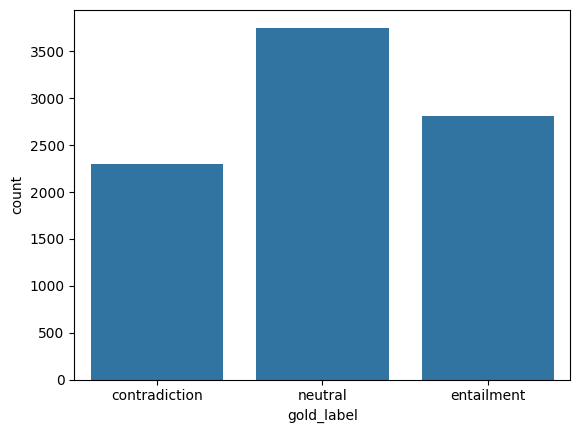

In [24]:
sns.countplot(train_data, x='gold_label')

<Axes: xlabel='gold_label', ylabel='count'>

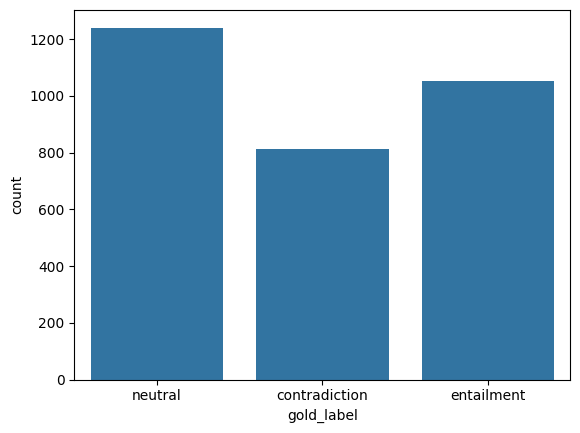

In [25]:
sns.countplot(test_data, x='gold_label')

### Running Model

In [26]:
# main: define X_train, X_test, y_train, and y_test

# Transform saprse matrix to numpy
# converts a matrix that only stores non-zero values and their positions into a matrix that includes all values, including zeros.
X_train1 = X_train1.todense().A
X_train2 = X_train2.todense().A
X_test1 = X_test1.todense().A
X_test2 = X_test2.todense().A

# The approach used to represent the input is going to be substraction (A sent_vector - B sent_vector)
# This subtraction results in a new vector that represents the semantic difference or relationship between the two sentences.
X_train = []
for i in range(0, X_train1.shape[0]):
    subs = X_train1[i] - X_train2[i]
    X_train.append(subs)
print('X_train Length:', len(X_train))
    
X_test = []
for i in range(0, X_test1.shape[0]):
    subs = X_test1[i] - X_test2[i]
    X_test.append(subs)

y_train = np.array(train_data['label'].values)
y_test = np.array(test_data['label'].values)
print('y_train Shape:', y_train.shape)

X_train Length: 8854
y_train Shape: (8854,)


In [27]:
# Models and corresponding parameter grids
models_params = [
    {
        'name': 'Logistic Regression',
        'model': LogisticRegression(n_jobs=-1),
        'params': {
            'solver' : ['newton-cg', 'saga', 'sag'],
            'C' : np.logspace(-10, 0, 10)
        }
    },
    {
        'name': 'KNN',
        'model': KNeighborsClassifier(n_jobs=-1),
        'params': {
            'n_neighbors' : [3, 5, 10],
            'weights': ["uniform", "distance"]
        },
    },
    {
        'name': 'SVC',
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['auto', 'scale']
        }
    },
    {
        'name': 'Random Forest Classifier',
        'model': RandomForestClassifier(n_jobs=-1),
        'params': {
            'n_estimators': [10,50,100],
            'criterion': ['gini', 'entropy']
        }
    }
]


In [28]:
# main: run model
t0 = time.time()
grid_searches = {} ## empty dictionary for the Grid.fit of each model
# Perform GridSearchCV for each model
for mp in models_params:
    model = mp['model']
    params = mp['params']
    model_name = mp['name']
    print('Running GridSearchCV for',model_name,'...')

    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    grid_searches[model_name] = grid_search
    
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
    print()
print('Done.')

# Note: You can then evaluate the best models on your test set (X_test, y_test) using grid_search.best_estimator_
print('Time in minutes:', (time.time() - t0)/60)

Running GridSearchCV for Logistic Regression ...
Best parameters for LogisticRegression: {'C': 0.07742636826811278, 'solver': 'sag'}
Best cross-validation accuracy: 0.4635

Running GridSearchCV for KNN ...
Best parameters for KNeighborsClassifier: {'n_neighbors': 10, 'weights': 'distance'}
Best cross-validation accuracy: 0.4628

Running GridSearchCV for SVC ...
Best parameters for SVC: {'C': 1, 'gamma': 'scale'}
Best cross-validation accuracy: 0.5372

Running GridSearchCV for Random Forest Classifier ...
Best parameters for RandomForestClassifier: {'criterion': 'gini', 'n_estimators': 100}
Best cross-validation accuracy: 0.5265

Done.
Time in minutes: 28.02245589494705


In [29]:
frames = []
for name, grid_search in grid_searches.items():
    frame = pd.DataFrame(grid_search.cv_results_) # The results for every combination of param
    frame = frame.filter(regex='^(?!.*param_).*$') # remove columns about GRID parameters
    frame['estimator'] = len(frame)*[name] # add the name of the model for every combo 
    frames.append(frame)
df = pd.concat(frames) # final dict of all the training that the grid model has done
# df = df.drop(['rank_test_score', 'index'], axis=1)

# Reorder the columns so estimator is the first one
# columns = df.columns.tolist() 
# print(columns)
df = df.reindex(columns=['estimator', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 
 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 
 'mean_test_score', 'std_test_score'])

results = df.sort_values(by='mean_test_score', ascending=False)
results = results.reset_index(drop=True)
cols = ['estimator', 'params', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
results = results[cols]
results.head(10)

,estimator,params,mean_test_score,mean_fit_time,mean_score_time
0,SVC,"{'C': 1, 'gamma': 'scale'}",0.537158,27.971685,7.544967
1,Random Forest Classifier,"{'criterion': 'gini', 'n_estimators': 100}",0.526542,4.333330,0.085516
2,Random Forest Classifier,"{'criterion': 'gini', 'n_estimators': 50}",0.523606,2.220263,0.048385
3,Random Forest Classifier,"{'criterion': 'entropy', 'n_estimators': 50}",0.522702,2.340462,0.048714
4,Random Forest Classifier,"{'criterion': 'gini', 'n_estimators': 10}",0.519878,0.615616,0.024768
5,Random Forest Classifier,"{'criterion': 'entropy', 'n_estimators': 100}",0.514909,4.463438,0.082727
6,SVC,"{'C': 10, 'gamma': 'scale'}",0.513779,30.799707,7.322948
7,Random Forest Classifier,"{'criterion': 'entropy', 'n_estimators': 10}",0.507453,0.607101,0.025095
8,SVC,"{'C': 0.1, 'gamma': 'scale'}",0.464875,26.667671,7.524965
9,Logistic Regression,"{'C': 0.07742636826811278, 'solver': 'sag'}",0.463520,2.455283,0.008803


<Axes: title={'center': 'mean_test_score'}, xlabel='estimator'>

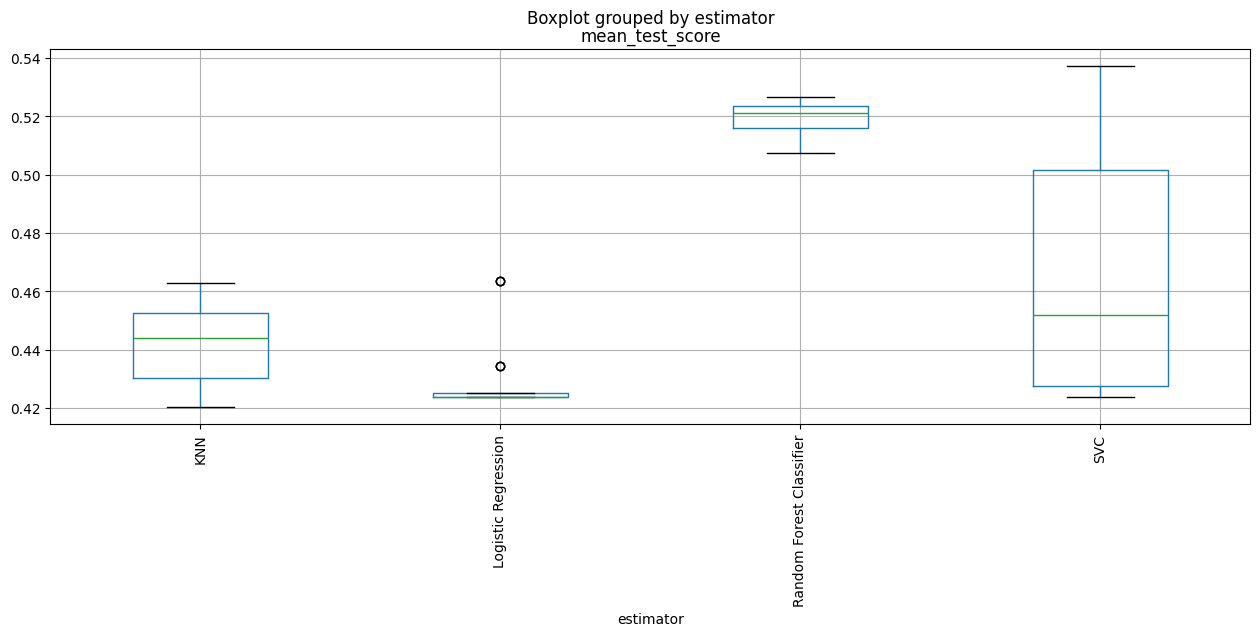

In [30]:
results.boxplot(column='mean_test_score',by='estimator', figsize=(15,5), rot=90)

### Testing

In [31]:
# Predictions for the test set
param = results.loc[0, 'params']
best_classifier = SVC(**param)
best_classifier.fit(X_train,y_train)
y_pred = best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1052
           1       0.66      0.79      0.72      1241
           2       0.82      0.57      0.67       812

    accuracy                           0.69      3105
   macro avg       0.72      0.68      0.69      3105
weighted avg       0.71      0.69      0.69      3105



Confusion Matrix:
[[708 299  45]
 [199 985  57]
 [152 201 459]]


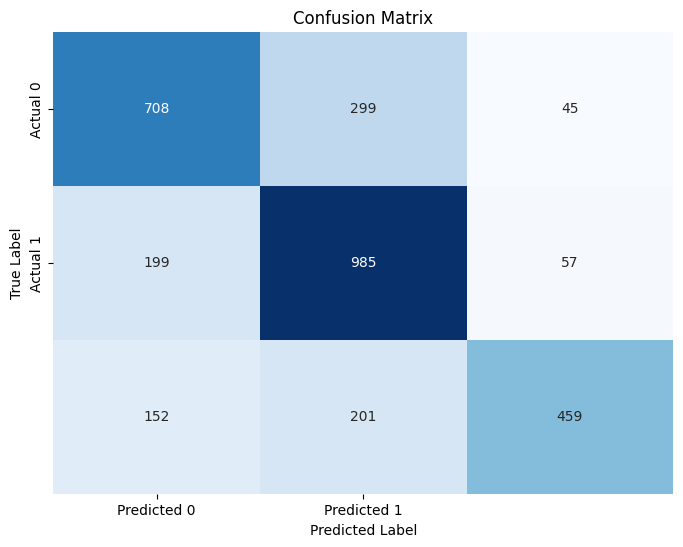

In [32]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Output the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [33]:
# Label the predictions with their correct name
labels_name = {0:'entailment', 1:'neutral', 2:'contradiction'}
label_pred = [labels_name[i] for i in y_pred] 

# Create a big data frame with the true labels and their predictions
final_df = test_data[['premise', 'hypothesis', 'gold_label']]
final_df['predictions'] = label_pred 
final_df.head(10)

,premise,hypothesis,gold_label,predictions
0,رجل يعزف على الفلوت,الرجل يلعب بمهارة على الغيتار,neutral,neutral
1,البغدادي المحمودي يعرض على المعارضة وقفا ل إط...,رئيس الحكومة الليبية مستعدون ل وقف إطلاق النا...,contradiction,contradiction
2,طفلان وشخص بالغ لا يقفون بجانب أحد أطراف الشجرة,يقف طفلان وشخص بالغ بجانب شجرة,contradiction,neutral
3,كلبان بنيان يلعبان مع الفريسبي في الماء,كلبان بنيان يلعبان مع الطائر الطائر في الماء,entailment,entailment
4,كان ستيف هاريس، عالم الأحياء الجزيئية من تكساس...,رفض ستيف هاريس مغادرة منزله لأي سبب.,contradiction,contradiction
5,شبل النمر يُصدر صوتًا,نمر يتجول,neutral,entailment
6,القواعد والتألق من الناحية التاريخية هي نفس ال...,الكلمات تفرقت في 1910 عندما سرق القيصر كل حروف...,neutral,neutral
7,وفقا للدعاية ، يحتوي الأول على 2000 إدخالات ، ...,على حد علمي، فإن ODNW يحتوي على معلومات أكثر م...,neutral,neutral
8,يعمل مدير قسم المعلومات بالشركة مع الرؤساء الت...,يرغب كبير موظفي المعلومات أن يحسن زملاؤه من أد...,neutral,entailment
9,ثانياً ، إن الضعف الجنسي هو بيئة سريعة الوتيرة...,الضعف الجنسي هو على مهل والاسترخاء.,contradiction,neutral
